## 1. Project Overview
This project aims to analyze regional sales performance to identify trends and optimize business strategies across different areas and product categories.


## 2. Business Problem
The company lacks visibility into regional sales performance and product-level trends, which limits the ability to allocate resources effectively and design data-driven strategies.

## 3. Data Source
- **Dataset Name:** *(Superstore Dataset)*  
- **Source:** *(Kaggle)*  
- **Format:** CSV  
- **Rows / Columns:** 9,994 rows / 21 columns  
- **Main Fields:**  
  - `Order ID`, `Order Date`, `Customer ID`, `Category`, `Sales`, etc.

*(Insert a small sample or screenshot of the first rows here if useful.)*


## 4. Database Setup (SQL Server)
**Database created:** `Superstore Dataset_DB`

**Steps:**
1. Imported the CSV into SQL Server Management Studio (SSMS). (as Superstore_Dataset_Original)
2. Created schema/DataBase;
    * analytics
    * SalesData
3. Create user;
    * usr_data_cleaning & usr_powerbi_viewer



###1. Imported the CSV into SQL Server Management Studio (SSMS). (as Superstore_Dataset_Original)

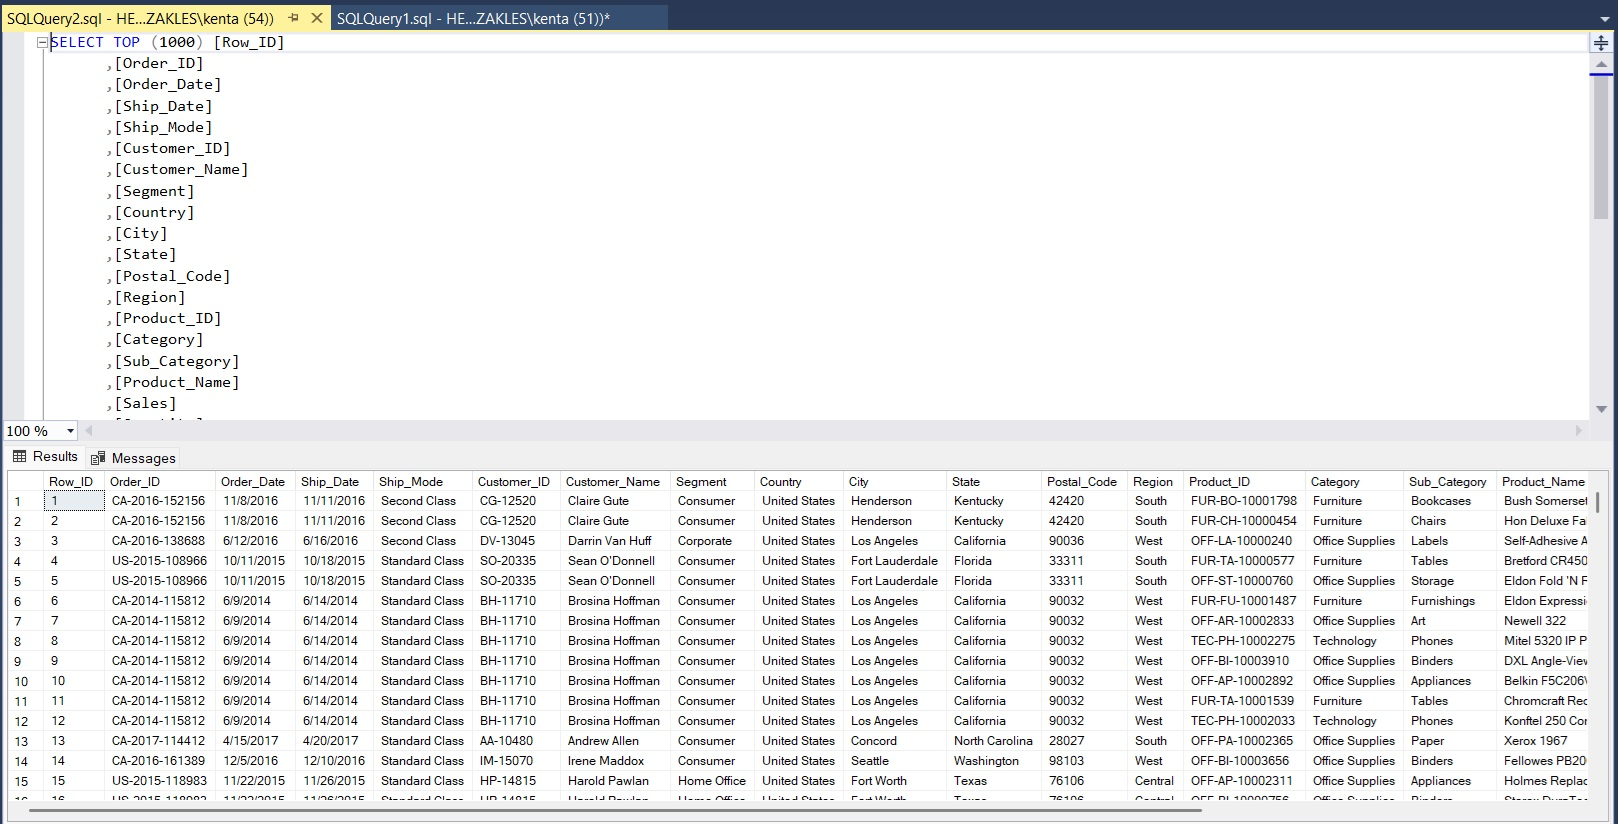

###2. Create schema & database

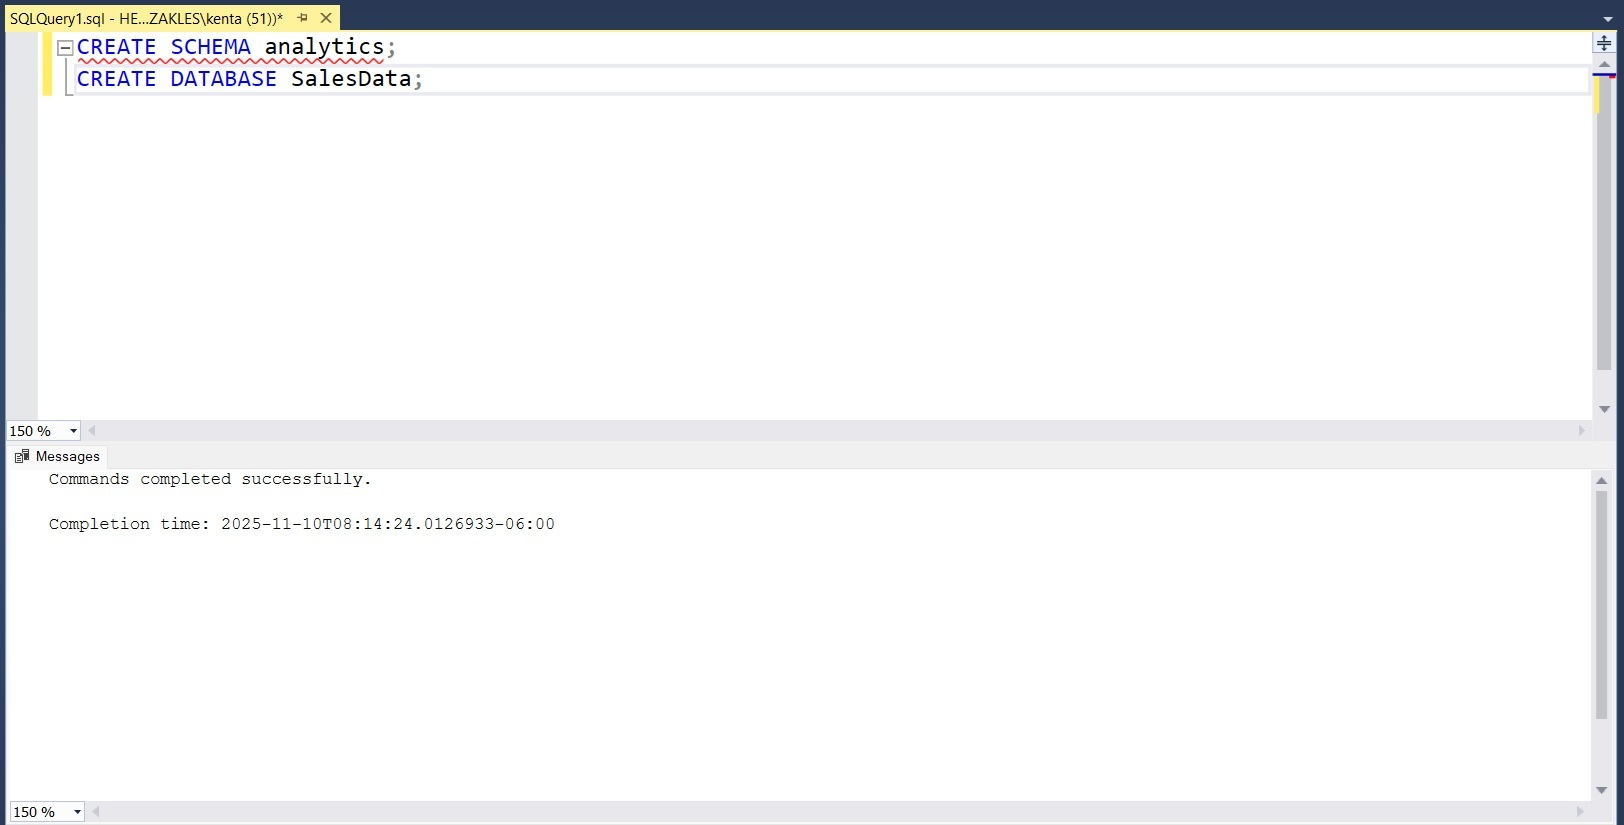

###3. Create users

Two SQL Server users were created using SSMS GUI:

1. **usr_data_cleaning** → granted full DML permissions (for data cleaning and preparation).

2. **usr_powerbi_viewer** → granted read-only access to cleaned and reporting tables.

This setup ensures proper data governance and aligns with professional best practices for separating analytical and operational roles.

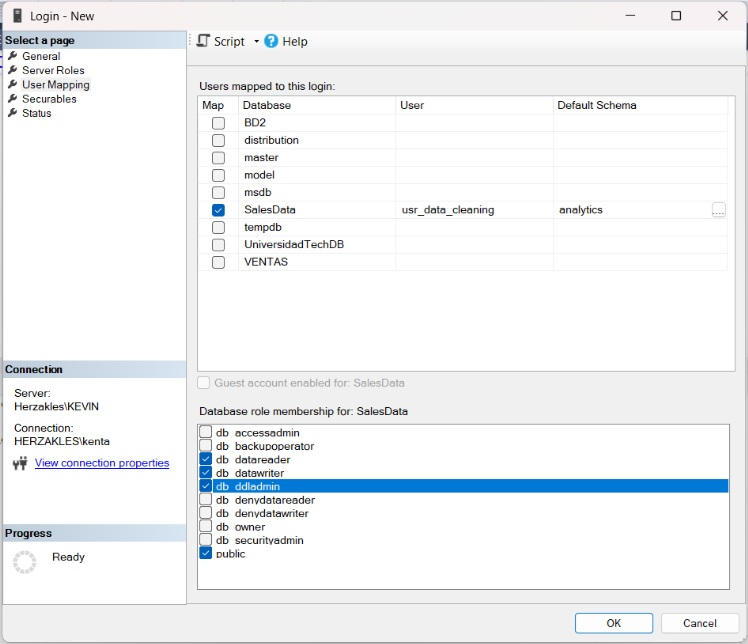

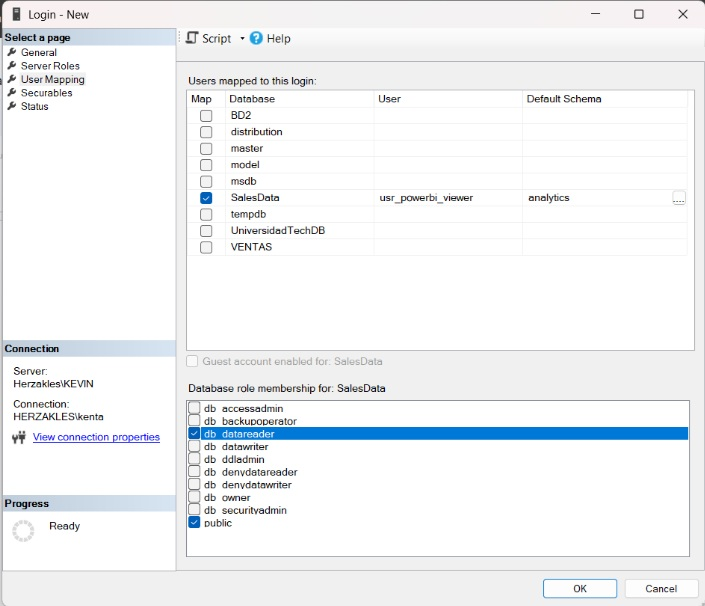

##5. Data Normalization & Cleaning
Actions performed:
1. Removed duplicates and nulls.
2. Ensured consistency on data type & naming.
3. Split data into reference tables: Regions, Products, and Sales.



###1. Removed duplicates and nulls.


* **Remove duplicates by columns. (Data showed 8 duplicated rows)**
```
WITH Cleaned AS (
    SELECT *,
           ROW_NUMBER() OVER (
               PARTITION BY [Order_ID], [Product_ID], [Order_Date]
               ORDER BY [Row_ID]
           ) AS rn
    FROM [analytics].[Superstore_Dataset_Original]

)
DELETE FROM Cleaned WHERE rn > 1;
```


* **Remove nulls by key columns (Data showed no nulls)**
```
DELETE FROM [analytics].[Superstore_Dataset_Original]
WHERE [Order_ID] IS NULL
   OR [Order_Date] IS NULL
   OR [Ship_Date] IS NULL
   OR [Ship_Mode] IS NULL
   OR [Customer_ID] IS NULL
   OR [Customer_Name] IS NULL
   OR [Segment] IS NULL
   OR [Country] IS NULL
   OR [City] IS NULL
   OR [State] IS NULL
   OR [Postal_Code] IS NULL
   OR [Region] IS NULL
   OR [Product_ID] IS NULL
   OR [Category] IS NULL
   OR [Sub_Category] IS NULL
   OR [Product_Name] IS NULL
   OR [Sales] IS NULL
   OR [Quantity] IS NULL
   OR [Discount] IS NULL
   OR [Profit] IS NULL;
```





###2. Ensured consistency on data type & naming.



* **Defined proper data type for each column on a new table (Superstore_Dataset_Cleaned)**


```
CREATE TABLE [analytics].[Superstore_Dataset_Cleaned] (
    Row_ID INT,
    Order_ID VARCHAR(20),
    Order_Date DATE,
    Ship_Date DATE,
    Ship_Mode VARCHAR(30),
    Customer_ID VARCHAR(15),
    Customer_Name VARCHAR(100),
    Segment VARCHAR(50),
    Country VARCHAR(50),
    City VARCHAR(100),
    State VARCHAR(100),
    Postal_Code VARCHAR(10),
    Region VARCHAR(50),
    Product_ID VARCHAR(20),
    Category VARCHAR(50),
    Sub_Category VARCHAR(50),
    Product_Name VARCHAR(255),
    Sales DECIMAL(10,2),
    Quantity INT,
    Discount DECIMAL(4,2),
    Profit DECIMAL(10,4)
);
```

* **Insert Cleaned & Transformed Data**
```
INSERT INTO [analytics].[Superstore_Dataset_Cleaned]
SELECT
    TRY_CAST(Row_ID AS INT),
    LTRIM(RTRIM(Order_ID)),
    TRY_CAST(Order_Date AS DATE),
    TRY_CAST(Ship_Date AS DATE),
    LTRIM(RTRIM(Ship_Mode)),
    LTRIM(RTRIM(Customer_ID)),
    LTRIM(RTRIM(Customer_Name)),
    LTRIM(RTRIM(Segment)),
    LTRIM(RTRIM(Country)),
    LTRIM(RTRIM(City)),
    LTRIM(RTRIM(State)),
    LTRIM(RTRIM(Postal_Code)),
    LTRIM(RTRIM(Region)),
    LTRIM(RTRIM(Product_ID)),
    LTRIM(RTRIM(Category)),
    LTRIM(RTRIM(Sub_Category)),
    LTRIM(RTRIM(Product_Name)),
    TRY_CAST(Sales AS DECIMAL(10,2)),
    TRY_CAST(Quantity AS INT),
    TRY_CAST(Discount AS DECIMAL(4,2)),
    TRY_CAST(Profit AS DECIMAL(10,4))
FROM [analytics].[Superstore_Dataset_Original];
```

* **Create Standarization Map Table to Handle Incorrect Values**
```
CREATE TABLE [analytics].[Standardization_Map] (
    Column_Name VARCHAR(50),
    Incorrect_Value VARCHAR(255),
    Correct_Value VARCHAR(255)
);
```

* **Populate Standarization Map with Incorrect Values**
```
-- This way allows us to standarize and automatize this process
-- Since Incorrect_Value Column does not have any errors,
-- We can just do this and fill out 2 columns with same info;

DECLARE @cols TABLE (Column_Name VARCHAR(100));
INSERT INTO @cols (Column_Name)
VALUES
('Ship_Mode'),
('Segment'),
('Country'),
('Region'),
('Category'),
('Sub_Category'),
('State'),
('City');

DECLARE @col VARCHAR(100);
DECLARE @sql NVARCHAR(MAX);

DECLARE col_cursor CURSOR FOR SELECT Column_Name FROM @cols;

OPEN col_cursor;
FETCH NEXT FROM col_cursor INTO @col;

WHILE @@FETCH_STATUS = 0
BEGIN
    SET @sql = N'
        INSERT INTO [analytics].[Standardization_Map] (Column_Name, Incorrect_Value, Correct_Value)
        SELECT DISTINCT
            ''' + @col + ''' AS Column_Name,
            LTRIM(RTRIM(' + QUOTENAME(@col) + ')) AS Incorrect_Value,
            LTRIM(RTRIM(' + QUOTENAME(@col) + ')) AS Correct_Value
        FROM [analytics].[Superstore_Dataset_Cleaned] AS t
        WHERE LTRIM(RTRIM(' + QUOTENAME(@col) + ')) IS NOT NULL
          AND NOT EXISTS (
              SELECT 1
              FROM [analytics].[Standardization_Map] AS m
              WHERE
                m.Column_Name = ''' + @col + '''
                AND LTRIM(RTRIM(m.Incorrect_Value)) = LTRIM(RTRIM(t.' + QUOTENAME(@col) + '))
          );';
    
    EXEC sp_executesql @sql;

    FETCH NEXT FROM col_cursor INTO @col;
END

CLOSE col_cursor;
DEALLOCATE col_cursor;


```


* **Apply Standarization Map over Superstore_Dataset_Cleaned**
```
--- There is no different info to apply into table, however,
--- this is how we would complete this stage of the process;

DECLARE
    @col VARCHAR(100),
    @sql NVARCHAR(MAX);

-- List Columns for Standarization
DECLARE @cols TABLE (Column_Name VARCHAR(100));
INSERT INTO @cols (Column_Name)
VALUES
('Ship_Mode'),
('Segment'),
('Country'),
('Region'),
('Category'),
('Sub_Category'),
('State'),
('City');

-- Define Cursor
DECLARE col_cursor CURSOR FOR
SELECT Column_Name FROM @cols;

OPEN col_cursor;
FETCH NEXT FROM col_cursor INTO @col;

-- Iterate Each Column
WHILE @@FETCH_STATUS = 0
BEGIN
    SET @sql = N'
        UPDATE s
        SET s.' + QUOTENAME(@col) + N' = m.Correct_Value
        FROM [analytics].[Superstore_Dataset_Cleaned] AS s
        INNER JOIN [analytics].[Standardization_Map] AS m
            ON m.Column_Name = @col
           AND LTRIM(RTRIM(s.' + QUOTENAME(@col) + N')) = LTRIM(RTRIM(m.Incorrect_Value))
        WHERE m.Correct_Value IS NOT NULL;';

    PRINT 'Actualizando columna: ' + @col;

    EXEC sp_executesql
        @sql,
        N'@col VARCHAR(100)',
        @col=@col;

    FETCH NEXT FROM col_cursor INTO @col;
END

-- Close Cursor
CLOSE col_cursor;
DEALLOCATE col_cursor;

```


###3. Split data into reference tables: Regions, Products, and Sales.


* **Split data into reference tables: Regions, Products, Clients and Sales**

```
CREATE TABLE [analytics].[Regions] (
    RegionID INT IDENTITY(1,1) PRIMARY KEY,
    Country NVARCHAR(100),
    State NVARCHAR(100),
    City NVARCHAR(100),
    Region NVARCHAR(100),
    UNIQUE (Country, State, City)
);

CREATE TABLE [analytics].[Products] (
    ProductID NVARCHAR(50) PRIMARY KEY,
    Product_Name NVARCHAR(200),
    Category NVARCHAR(100),
    Sub_Category NVARCHAR(100)
);

CREATE TABLE [analytics].[Clients] (
    Customer_ID NVARCHAR(50) PRIMARY KEY,
    Customer_Name NVARCHAR(150),
    Segment NVARCHAR(100)
);

CREATE TABLE [analytics].[Sales] (
    Row_ID INT PRIMARY KEY,
    Order_ID NVARCHAR(50),
    Order_Date DATE,
    Ship_Date DATE,
    Ship_Mode NVARCHAR(100),
    Postal_Code NVARCHAR(20),
    RegionID INT,
    ProductID NVARCHAR(50),
    Customer_ID NVARCHAR(50),
    Sales DECIMAL(18,2),
    Quantity INT,
    Discount DECIMAL(5,2),
    Profit DECIMAL(18,2),
    FOREIGN KEY (RegionID) REFERENCES [analytics].[Regions](RegionID),
    FOREIGN KEY (ProductID) REFERENCES [analytics].[Products](ProductID),
    FOREIGN KEY (Customer_ID) REFERENCES [analytics].[Clients](Customer_ID)
);
```

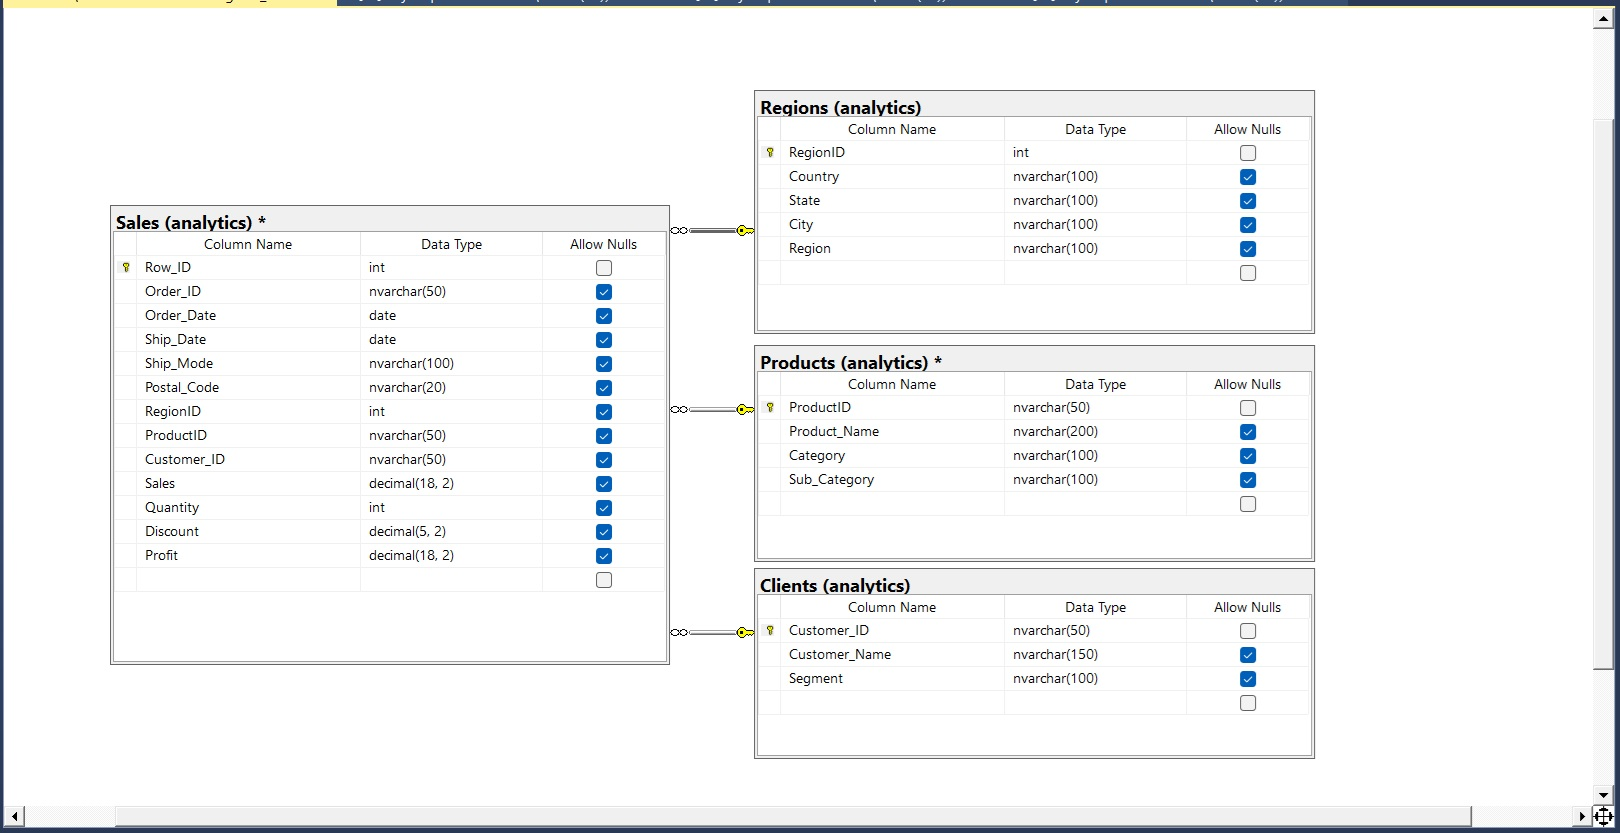

* **Populate Reference Tables**
```
-- Regions
INSERT INTO [analytics].[Regions] (Country, State, City, Region)
SELECT DISTINCT
    [Country],
    [State],
    [City],
    [Region]
FROM [analytics].[Superstore_Dataset_Cleaned]
WHERE Country IS NOT NULL;

-- Products
INSERT INTO [analytics].[Products] (ProductID, Product_Name, Category, Sub_Category)
SELECT
    Product_ID,
    MAX(Product_Name) AS Product_Name,
    MAX(Category) AS Category,
    MAX(Sub_Category) AS Sub_Category
FROM analytics.Superstore_Dataset_Cleaned
WHERE Product_ID IS NOT NULL
GROUP BY Product_ID;

-- Clients
INSERT INTO [analytics].[Clients] (Customer_ID, Customer_Name, Segment)
SELECT DISTINCT
    [Customer_ID],
    [Customer_Name],
    [Segment]
FROM [analytics].[Superstore_Dataset_Cleaned]
WHERE Customer_ID IS NOT NULL;

-- Sales
INSERT INTO [analytics].[Sales] (
    Row_ID, Order_ID, Order_Date, Ship_Date, Ship_Mode, Postal_Code,
    RegionID, ProductID, Customer_ID, Sales, Quantity, Discount, Profit
)
SELECT
    Row_ID,
    [Order_ID],
    [Order_Date],
    [Ship_Date],
    [Ship_Mode],
    [Postal_Code],
    r.RegionID,
    p.ProductID,
    c.Customer_ID,
    s.Sales,
    s.Quantity,
    s.Discount,
    s.Profit
FROM [analytics].[Superstore_Dataset_Cleaned] s
JOIN [analytics].[Regions] r
  ON r.Country = s.[Country]
 AND r.State   = s.[State]
 AND r.City    = s.[City]
JOIN [analytics].[Products] p
  ON p.ProductID = s.[Product_ID]
JOIN [analytics].[Clients] c
  ON c.Customer_ID = s.[Customer_ID];

```



At this stage, it’s best to leave the **Product_Name** column as is, since it contains full descriptive sentences and variations that would require semantic interpretation. Cleaning it could risk losing meaningful information and is beyond the scope of this analysis.


##6. Exploratory SQL Analysis
Key Queries:

1. Total Sales by Region

2. Profit Margin by Product Category

3. Monthly Sales Trend


(Include result tables or SSMS screenshots.)

###1. Total Sales by Region


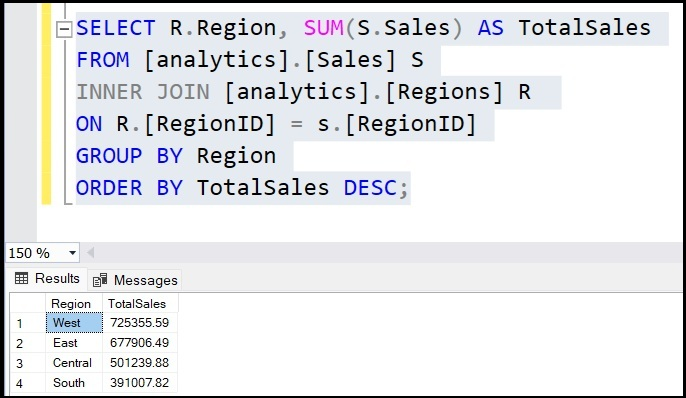

###2. Profit Margin by Product Category


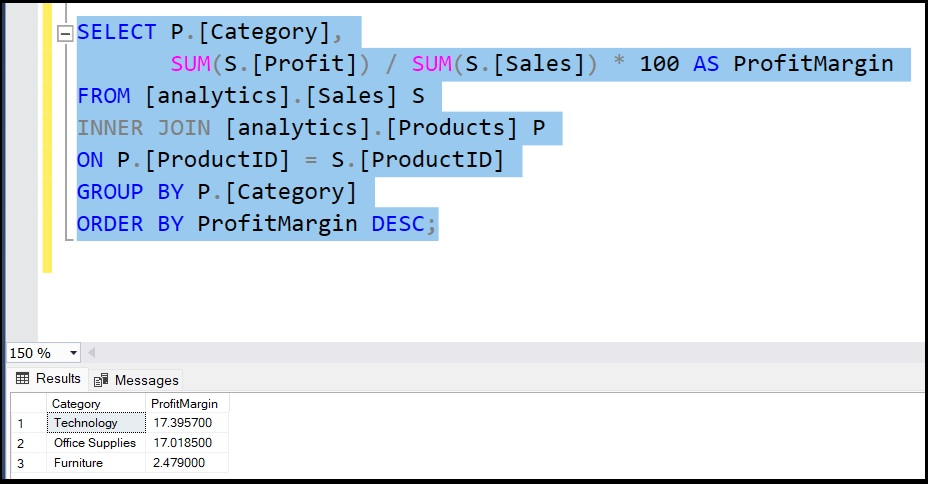

###3. Monthly Sales Trend


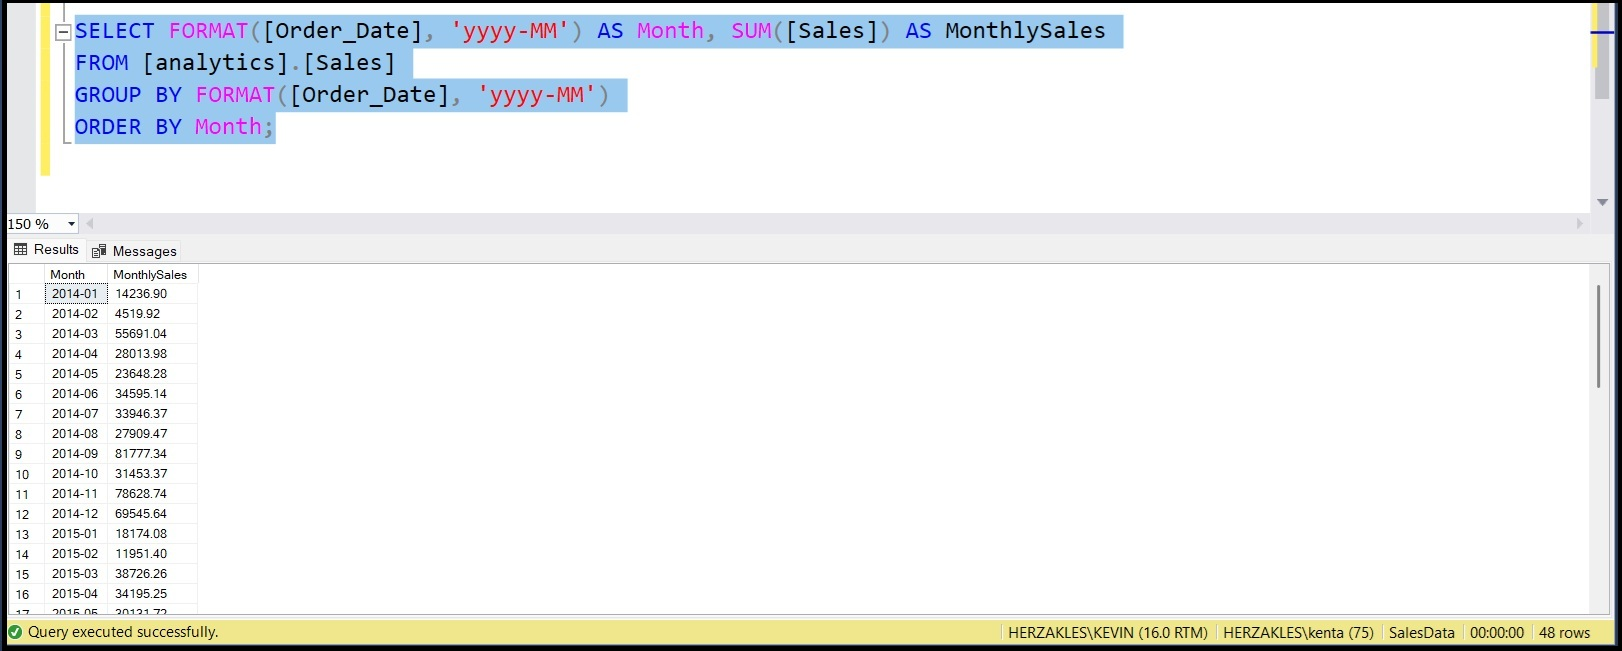


As a reference:
```
SELECT TOP (1000) *
  FROM [SalesData].[analytics].[Sales]



SELECT R.[Region], SUM(S.Sales) AS TotalSales
FROM [analytics].[Sales] S
INNER JOIN [analytics].[Regions] R
ON R.[RegionID] = S.[RegionID]
GROUP BY R.[Region]
ORDER BY TotalSales DESC;


SELECT P.[Category],
       SUM(S.[Profit]) / SUM(S.[Sales]) * 100 AS ProfitMargin
FROM [analytics].[Sales] S
INNER JOIN [analytics].[Products] P
ON P.[ProductID] = S.[ProductID]
GROUP BY P.[Category]
ORDER BY ProfitMargin DESC;



SELECT FORMAT([Order_Date], 'yyyy-MM') AS Month, SUM([Sales]) AS MonthlySales
FROM [analytics].[Sales]
GROUP BY FORMAT([Order_Date], 'yyyy-MM')
ORDER BY Month;


##7. Power BI Visualization
Dashboard Components

* Sales by Region: Map and bar chart.

* Top Product Categories: Pie and column chart.

* Monthly Trends: Line chart by month.

* KPIs: Total Sales, Average Profit Margin, and Top Region.


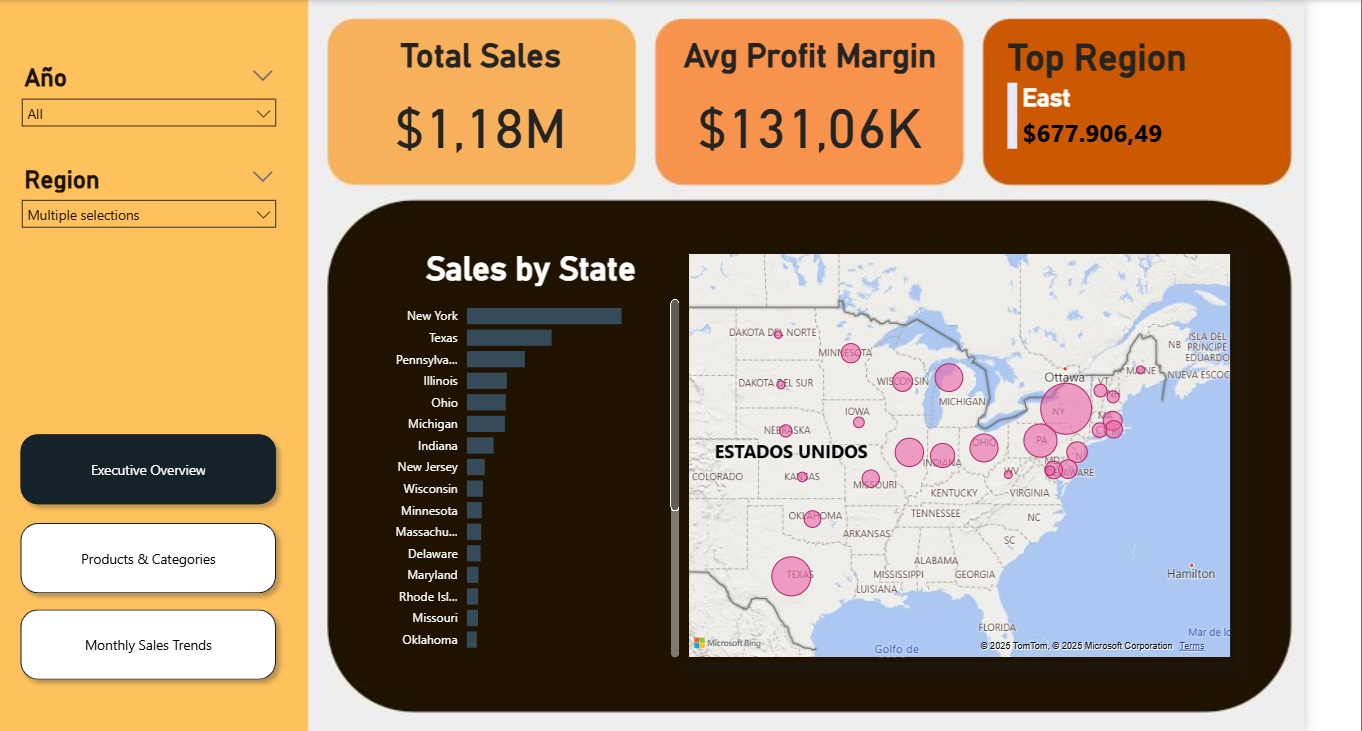

##8. Key Insights

* The South Region shows the highest revenue and profit margin.

* Tecnology and Office Supplies categories show the highest performace across regions.

* Seasonal spikes observed in September, November and December.

* Profitability strongly correlates with discount rates.

##9. Business Impact / Recommendations

* Optimize product pricing to improve profit margins.

* Adjust inventory based on seasonal sales patterns.

* Focus training for sales teams in low-performing areas.